In [1]:
# imports 
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
import time
seed = 1
np.random.seed(seed)

# from matplotlib.font_manager import FontProperties
# from matplotlib.ticker import MaxNLocator
# import matplotlib
# fontP = FontProperties()
# fontP.set_size('xx-small')
# matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['font.family'] = 'STIXGeneral'
# plt.rcParams['grid.alpha'] = 0.5
# plt.rc('grid', linestyle="--", color='grey')
# matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$');
# figsize = (12,8)


plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.dpi'] = 80

In [9]:
hidden_u = []
m = 3
dim = 2
bounds = [1.6, 4]
n = 10


In [10]:
def get_regularised_bn_mlp(input_shape, m, hidden_units, l2_reg_coeff = None, dropout_rate = None):
    """
    This function is used to build the MLP model. It takes input_shape and hidden_units
    as arguments, which should be used to build the model as described above, using the
    functional API.
    Your function should return the model.
    """
    inputs = tf.keras.layers.Input(shape=(input_shape,), name = 'state')
    # h = inputs
    h = tf.keras.layers.Dense(m, activation=tf.math.cos, 
                              kernel_initializer=tf.random_normal_initializer,
                              bias_initializer= tf.random_uniform_initializer(0, 2*  np.pi), 
                              trainable=False, name = '1st_hidden')(inputs)
    h = np.sqrt(2) * h 
    for units in hidden_units:
        h = tf.keras.layers.Dense(units, activation='linear')(h)
    # use bias is false because the derivative of a constant number (bias) is just zero
    outputs = tf.keras.layers.Dense(1, kernel_initializer = tf.zeros_initializer(),activation=None, name = 'output_layer', use_bias=False, trainable=True)(h)
    # outputs = outputs / m 
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

model = get_regularised_bn_mlp(input_shape=dim, m = m, hidden_units= hidden_u)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 state (InputLayer)          [(None, 2)]               0         
                                                                 
 1st_hidden (Dense)          (None, 3)                 9         
                                                                 
 tf.math.multiply_1 (TFOpLam  (None, 3)                0         
 bda)                                                            
                                                                 
 output_layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 12
Trainable params: 3
Non-trainable params: 9
_________________________________________________________________


In [11]:
# def kernel(x, y):
#     # x and y are two dimensional
#     intermediate_output = tf.keras.Model(model.input, model.get_layer('1st_hidden').output)
#     phi_x = intermediate_output(x)
#     phi_y = intermediate_output(y)
#     kernel_xy = phi_x * phi_y
#     return kernel_xy

# my_kernel = np.empty((n,n))

# xs = np.zeros((n,dim))
# ys = np.array([np.random.uniform(-bounds[0], bounds[0],n), np.random.uniform(-bounds[1],bounds[1],n)]).T

# for ind1, i in enumerate(xs):
#     i = i[tf.newaxis, ...]
#     for ind2, j in enumerate(ys):
#         # print(i[tf.newaxis, ...])
#         # print(j.reshape((1,2)))
#         j = j[tf.newaxis, ...]
#         # print(i.shape)
#         # print(j.shape)
#         # print(kernel(i[tf.newaxis, ...],j.reshape((1,2))))
#         # print(kernel(i,j).shape)
#         # print('----')
#         my_kernel[ind1, ind2] = kernel(i,j)
# my_kernel


In [12]:
# plt.contour(ys[:,0], ys[:,1], my_kernel)

In [18]:
# trial_data = np.array([np.random.uniform(-bounds[0], bounds[0],n), np.random.uniform(-bounds[1],bounds[1],n)]).T

trial_data = np.array([np.linspace(-1.6,1.6, n),np.linspace(-4,4, n)]).T

intermediate_output1 = tf.keras.Model(model.input, model.get_layer('1st_hidden').output)
phi_0 = intermediate_output1(tf.zeros((n, dim)))
phi_0 = phi_0[0]
phi_0

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.9150066 , -0.03507371, -0.14702831], dtype=float32)>

In [17]:
intermediate_output2 = tf.keras.Model(model.input, model.get_layer('1st_hidden').output)
phi_y = intermediate_output2(trial_data)
phi_y

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[ 0.6391629 , -0.2739023 , -0.1835058 ],
       [ 0.71463454, -0.22173063, -0.17541957],
       [ 0.7825765 , -0.16891593, -0.16732158],
       [ 0.8422729 , -0.11561088, -0.1592123 ],
       [ 0.8930948 , -0.06197102, -0.15109226],
       [ 0.9345066 , -0.00815095, -0.14296189],
       [ 0.966072  ,  0.04569228, -0.13482198],
       [ 0.9874586 ,  0.09940347, -0.12667297],
       [ 0.9984408 ,  0.1528259 , -0.11851539],
       [ 0.9989031 ,  0.20580512, -0.11034969]], dtype=float32)>

In [46]:
# this is the inner product (nope)
inn_p = phi_0 * phi_y

# all1 = tf.tensordot(inn_p, tf.transpose(inn_p), 1)
all1 = tf.tensordot(phi_y, phi_0, 1)
# print(all1)
# all1, all2 = np.array(np.meshgrid(all1, all1))
# all1

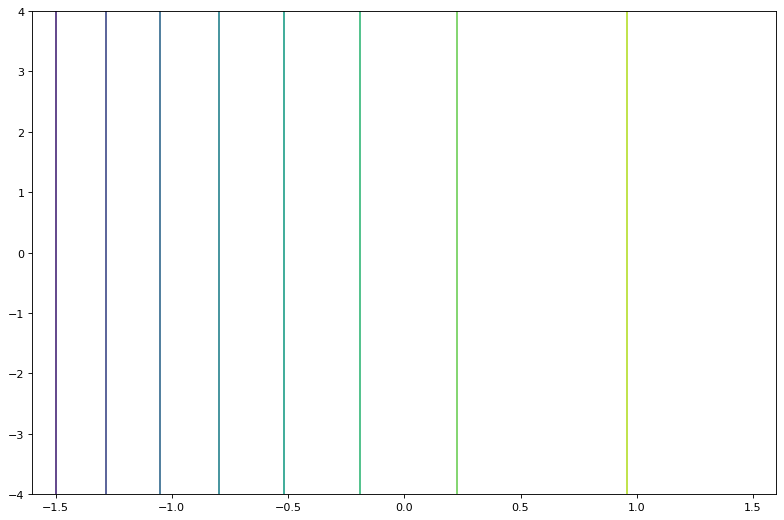

In [47]:
XX,YY = np.meshgrid(trial_data[:,0],trial_data[:,1])

plt.contour(XX, YY,all1)

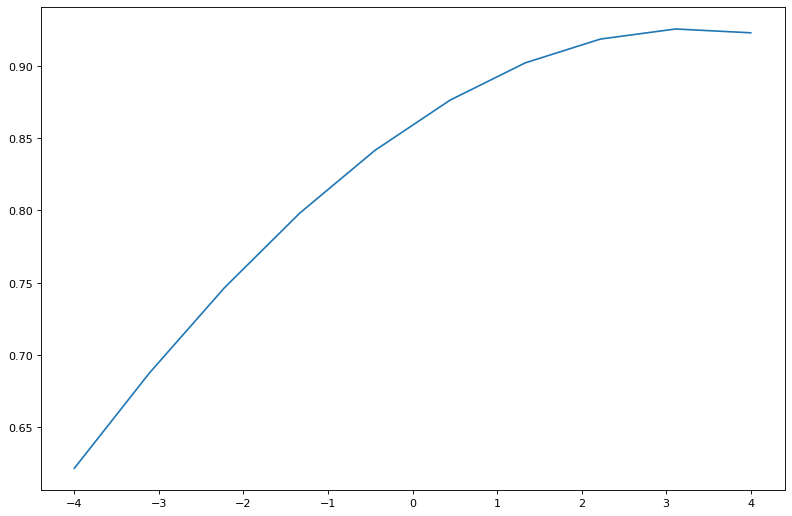

In [25]:
plt.plot(trial_data[:,1], all1)

RuntimeError: Error in qhull Delaunay triangulation calculation: singular input data (exitcode=2); use python verbose option (-v) to see original qhull error.

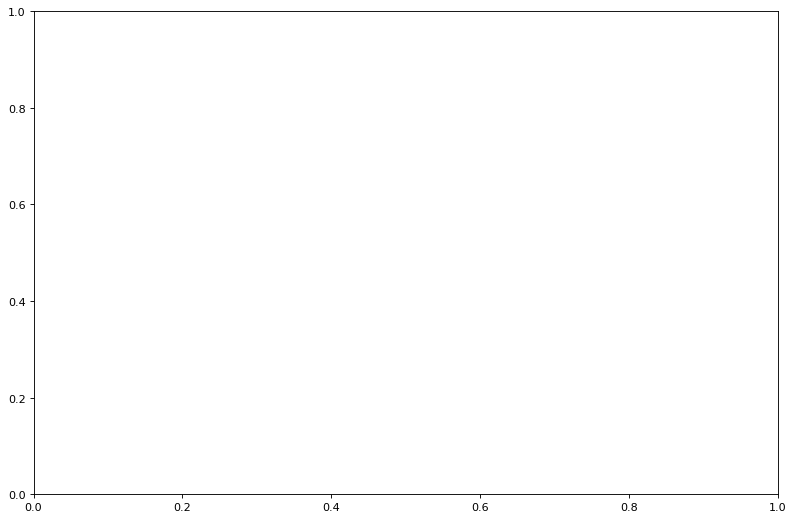

In [26]:
plt.tricontourf(trial_data[:,0], trial_data[:,1], all1)
plt.show()

In [240]:
K_trial = tf.tensordot(phi_0, tf.transpose(phi_y), axes = 1)

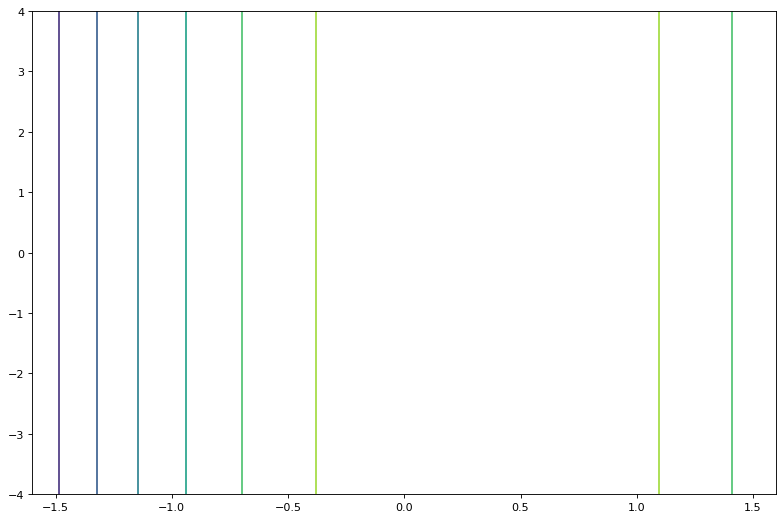

In [241]:
x = np.linspace(-4,4, n)
plt.contour(trial_data[:,0], trial_data[:,1], K_trial)
# plt.contour(x, x, K_trial)